# Data Prep and Churn Modeling

In [77]:
# Import necessary libaries
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import statsmodels.api as sm

# show all columns and rows 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Prep

In [78]:
# read in the csv files
demog_df = pd.read_csv('demog_pmm_data.csv')
# sort based on demog_age and then drop duplicates based on acct_id by keeping the first instance
demog_df.sort_values(by=['demog_age'], inplace=True)
demog_df.drop_duplicates(subset='acct_ID', keep='first', inplace=True)


In [79]:
churn_df = pd.read_csv('TP_churn_data.csv')
margin_df = pd.read_csv('TP_margin_data.csv')

# check if the order of acct_ID is the same in combined_df and churn_df
margin_df['acct_ID'].equals(churn_df['acct_ID']) # True


True

In [80]:
# Since the margin data and churn df have the same order of acct_ID, we can just add the margin data to the churn df and drop one of the acct_ID columns
churn_df = churn_df.drop('acct_ID', axis=1)
combined_df = pd.concat([churn_df, margin_df], axis=1)


In [81]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240368 entries, 0 to 240367
Columns: 127 entries, ST to acct_ID
dtypes: float64(100), int64(18), object(9)
memory usage: 232.9+ MB


In [82]:
# sort based on activation_date and then drop duplicates based on acct_id by keeping the first instance
combined_df.sort_values(by=['activation_date'], inplace=True)
combined_df.drop_duplicates(subset=['acct_ID'], keep='first', inplace=True)

In [83]:
# print info about the dataframes
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239356 entries, 136362 to 113125
Columns: 127 entries, ST to acct_ID
dtypes: float64(100), int64(18), object(9)
memory usage: 233.7+ MB
None


In [84]:
# join churn dataframes on acct_ID
combined_df = pd.merge(combined_df, demog_df, on='acct_ID')

# print the first 5 rows of the dataframe
combined_df.head()

,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_cnt_life,purch_amt_life,purch_cnt_cc_36mo,purch_cnt_et_36mo,purch_cnt_ck_36mo,purch_cnt_tt_36mo,purch_amt_36mo,purch_avg_36mo,purch_avg_interval,mail_cnt_36mo,resp_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,order_cnt_36mo,tier,tier_prev,activation_date,event_date,churn_year_plus1_ind,trans_amt_t_minus_00,trans_amt_t_minus_01,trans_amt_t_minus_02,trans_amt_t_minus_03,trans_amt_t_minus_04,trans_amt_t_minus_05,trans_amt_t_minus_06,trans_amt_t_minus_07,trans_amt_t_minus_08,trans_amt_t_minus_09,trans_amt_t_minus_10,trans_amt_t_minus_11,trans_amt_t_minus_12,trans_amt_t_minus_13,trans_amt_t_minus_14,trans_amt_t_minus_15,trans_amt_t_minus_16,trans_amt_t_minus_17,trans_amt_t_minus_18,trans_amt_t_minus_19,trans_amt_t_minus_20,trans_amt_t_minus_21,trans_amt_t_minus_22,trans_amt_t_minus_23,trans_amt_t_minus_24,trans_amt_t_minus_25,trans_amt_t_minus_26,trans_amt_t_minus_27,trans_amt_t_minus_28,trans_amt_t_minus_29,trans_amt_t_minus_30,trans_amt_t_minus_31,trans_amt_t_minus_32,trans_amt_t_minus_33,trans_amt_t_minus_34,trans_amt_t_minus_35,trans_amt_t_plus_01,trans_amt_t_plus_02,trans_amt_t_plus_03,trans_amt_t_plus_04,trans_amt_t_plus_05,trans_amt_t_plus_06,trans_amt_t_plus_07,trans_amt_t_plus_08,trans_amt_t_plus_09,trans_amt_t_plus_10,trans_amt_t_plus_11,trans_amt_t_plus_12,cost_amt_t_minus_35,cost_amt_t_minus_34,cost_amt_t_minus_33,cost_amt_t_minus_32,cost_amt_t_minus_31,cost_amt_t_minus_30,cost_amt_t_minus_29,cost_amt_t_minus_28,cost_amt_t_minus_27,cost_amt_t_minus_26,cost_amt_t_minus_25,cost_amt_t_minus_24,cost_amt_t_minus_23,cost_amt_t_minus_22,cost_amt_t_minus_21,cost_amt_t_minus_20,cost_amt_t_minus_19,cost_amt_t_minus_18,cost_amt_t_minus_17,cost_amt_t_minus_16,cost_amt_t_minus_15,cost_amt_t_minus_14,cost_amt_t_minus_13,cost_amt_t_minus_12,cost_amt_t_minus_11,cost_amt_t_minus_10,cost_amt_t_minus_09,cost_amt_t_minus_08,cost_amt_t_minus_07,cost_amt_t_minus_06,cost_amt_t_minus_05,cost_amt_t_minus_04,cost_amt_t_minus_03,cost_amt_t_minus_02,cost_amt_t_minus_01,cost_amt_t_minus_00,cost_amt_t_plus_01,cost_amt_t_plus_02,cost_amt_t_plus_03,cost_amt_t_plus_04,cost_amt_t_plus_05,cost_amt_t_plus_06,cost_amt_t_plus_07,cost_amt_t_plus_08,cost_amt_t_plus_09,cost_amt_t_plus_10,cost_amt_t_plus_11,cost_amt_t_plus_12,acct_ID,demog_assets,demog_LOR,demog_ownrent,demog_age,demog_span,demog_inc_fine,demog_inc_crs,demog_generations,demog_homevalue,demog_adults
0,CA,95204,862,209,1,1,1,0,1,1,49,44,1435.0,33,0,3,36,1240.0,34.44,1.12,36,1,3,4,11,2-Silver,1-Bronze,01AUG10,NaN,0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,40.0,40.0,40.0,36.0,36.0,36.0,36.0,116.0,36.0,36.0,63.0,36.0,36.0,36.0,36.0,36.0,0.0,0.0,0.0,30.0,55.0,30.0,30.0,30.0,30.0,30.0,30.0,50.0,30.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,7.01,6.48,6.21,5.33,1.12,1.72,6.10,0.90,1.84,1.92,5.24,5.62,0.52,1.24,4.31,4.64,1.24,1.88,2.44,4.22,3.07,4.11,3.89,1.54,2.13,7.76,3.29,1.80,1.54,1.47,4.45,0.80,0.94,4.79,0.90,1.78,5.06,6.23,4.87,4.95,2.32,1.50,4.24,1.2,2.46,4.44,2.62,2.36,I137324484,IPA <= 25000,19 - 24 Months,Definite Owner (any type dwelling unit),35-44 years old,0,Less than $15000,Less than $15000,1,$ 50000 - $ 99999,1
1,TX,75169,623,417,0,1,1,0,1,1,49,53,1315.0,33,0,2,35,805.0,23.00,1.04,35,1,1,3,6,1-Bronze,xxx,01AUG10,NaN,0,25.0,25.0,25.0,25.0,50.0,25.0,25.0,25.0,50.0,0.0,0.0,0.0,25.0,25.0,25.0,25.0,25.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,45.0,20.0,20.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,0.60,1.46,4.22,1.50,0.86,2.29,6.10,0.90,1.54,1.92,4.98,3.80,2.11,1.24,4.01,1.58,1.24,1.88,1.67,4.22,3.07,1.97,3.59,1.54,1.24,1.50,6.05,1.32,4.25,1.47,4.45,2.77,1.54,4.23,1.16,1.78,5.06,5.16,4.90,2.41,2.06,1.50,4.24,1.2,1.86,4.18,2.89,2.36,I78608548,IPA <= 25000,9th Year,Definite Owner (any type dwelling unit),75+ years old,0,$ 20000 - $ 29999,$ 15000 - $ 29999,1,$ 50000 - $ 99999,1


In [85]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239356 entries, 0 to 239355
Columns: 137 entries, ST to demog_adults
dtypes: float64(100), int64(21), object(16)
memory usage: 252.0+ MB


In [86]:
# nunique for df acct_ID
print(combined_df['acct_ID'].nunique())

239356


In [87]:
# export to csv
combined_df.to_csv('combined_data_raw.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'combined_data_raw.csv'

# EDA (Churn)

<AxesSubplot:title={'center':'Distribution of Purchase Amount'}, ylabel='Frequency'>

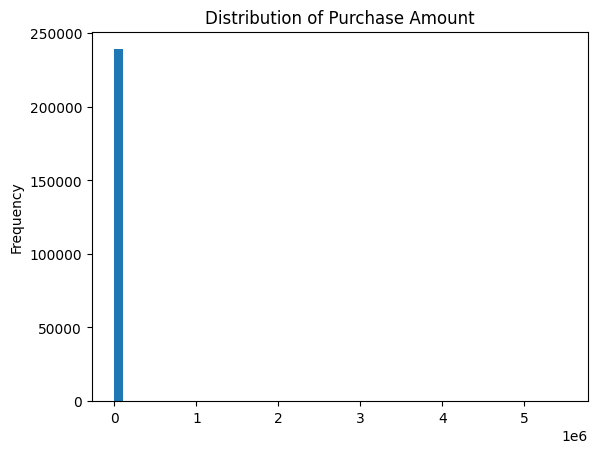

In [ ]:
combined_df['purch_amt_life'].plot.hist(title="Distribution of Purchase Amount",bins=50)

<AxesSubplot:title={'center':'Distribution of Purchase Amount'}, ylabel='Frequency'>

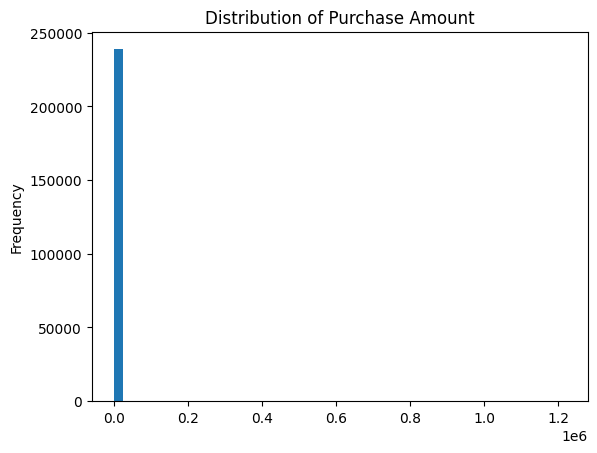

In [ ]:
combined_df['purch_amt_36mo'].plot.hist(title="Distribution of Purchase Amount",bins=50)

<AxesSubplot:title={'center':'Distribution of Purchase Amount'}, ylabel='Frequency'>

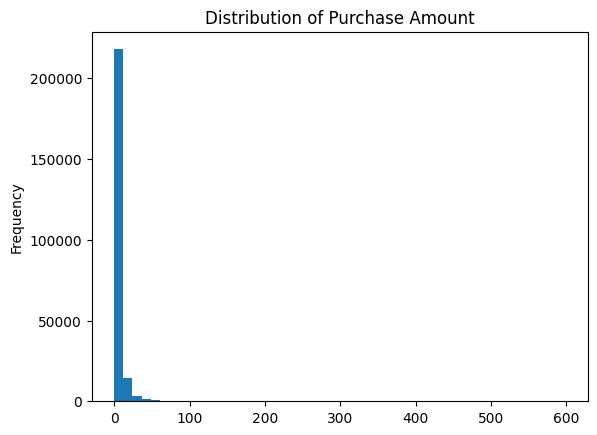

In [ ]:
combined_df['order_cnt_36mo'].plot.hist(title="Distribution of Purchase Amount",bins=50)

<AxesSubplot:title={'center':'Distribution of Purchase Amount'}, ylabel='Frequency'>

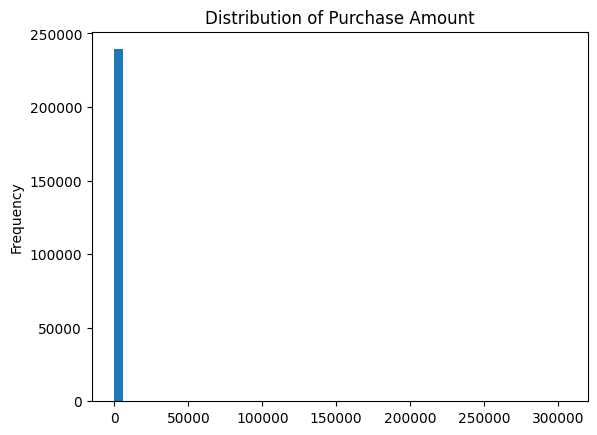

In [ ]:
combined_df['purch_avg_36mo'].plot.hist(title="Distribution of Purchase Amount",bins=50)

<AxesSubplot:title={'center':'Distribution of Purchase Amount'}, ylabel='Frequency'>

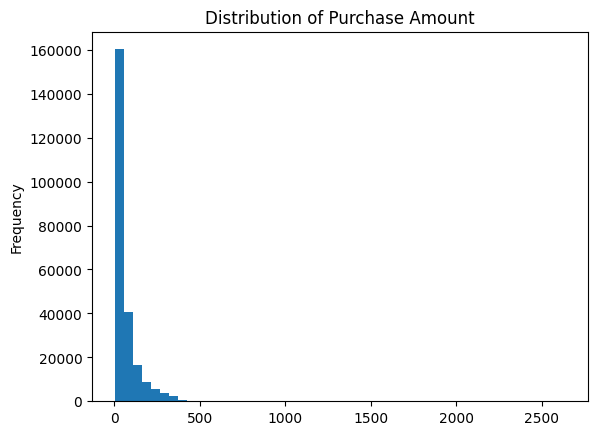

In [ ]:
combined_df['purch_cnt_life'].plot.hist(title="Distribution of Purchase Amount",bins=50)

<AxesSubplot:title={'center':'Distribution of Purchase Amount'}, ylabel='Frequency'>

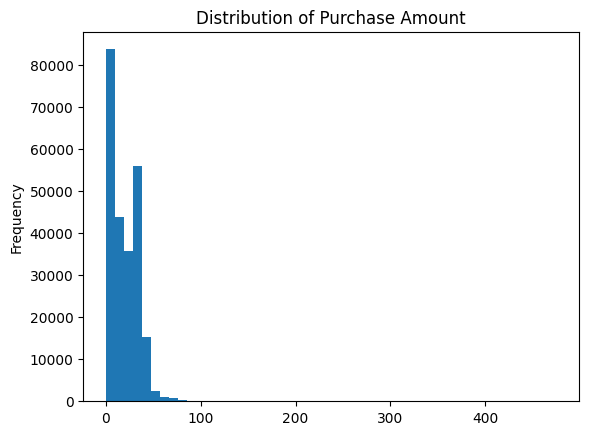

In [ ]:
combined_df['purch_cnt_tt_36mo'].plot.hist(title="Distribution of Purchase Amount",bins=50)

<AxesSubplot:title={'center':'Distribution of Purchase Amount'}, ylabel='Frequency'>

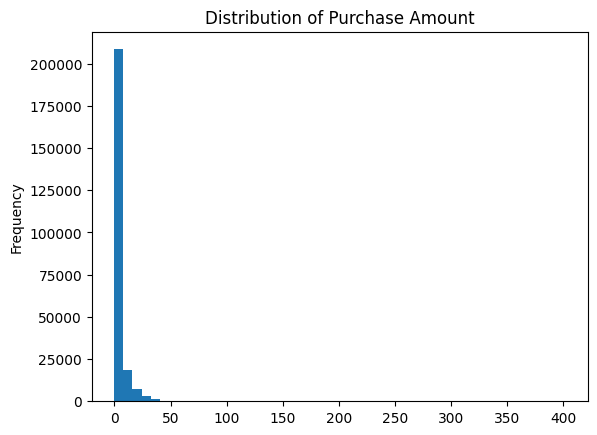

In [ ]:
combined_df['resp_cnt_36mo'].plot.hist(title="Distribution of Purchase Amount",bins=50)

<AxesSubplot:title={'center':'Distribution of months_since_last_trans'}, ylabel='Frequency'>

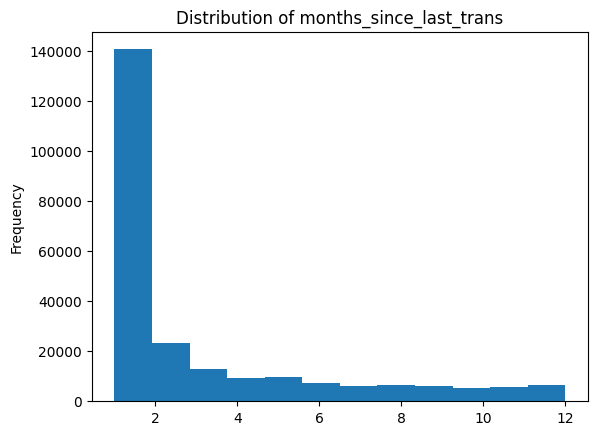

In [91]:
combined_df['months_since_last_trans'].plot.hist(title="Distribution of months_since_last_trans",bins=12)

In [ ]:
combined_df['months_since_last_36'].plot.hist(title="Distribution of Purchase Amount",bins=50)

# Feature Engineering (Churn)

In [19]:
# list all the ST unique values
print(combined_df['ST'].unique())

['CA' 'TX' 'SC' 'RI' 'MT' 'VA' 'FL' 'GA' 'MD' 'WA' 'TN' 'OR' 'MI' 'IN'
 'SD' 'WV' 'MN' 'OK' 'MO' 'AR' 'NC' 'CO' 'AL' 'OH' 'LA' 'KY' 'NJ' 'NY'
 'NH' 'PA' 'IL' 'WI' 'CT' 'KS' 'AZ' 'NM' 'ME' 'NE' 'MS' 'ND' 'NV' 'ID'
 'MA' 'WY' 'missing' 'IA' 'DC' 'AE' 'HI' 'UT' 'DE' 'AK' 'VI' 'PR' 'VT'
 'AP' 'GU' 'MP' 'AS' 'AA' 'MH']


In [20]:
# Do feature engineering on 'ST' to regions in the US
# create a dictionary to map the states to regions

state_region_dict = {
    "Northeast": ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT'],
    "Midwest": ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI'],
    "South": ['AL', 'AR', 'DE', 'DC', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV'],
    "West": ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY'],
    "Territories": ['AS', 'GU', 'MP', 'PR', 'VI', 'MH'],
    "Military": ['AE', 'AP', 'AA'],
    "Missing": ['missing']
}

# create a new column 'region' and map the states to the regions
combined_df['region'] = combined_df['ST'].map(
    {state: region for region, states in state_region_dict.items() for state in states})

# print the first 5 rows of the dataframe
combined_df[['ST', 'region']].head()

,ST,region
0,CA,West
1,TX,South
2,SC,South
3,RI,Northeast
4,MT,West


In [21]:
# # export to csv
combined_df.to_csv('combined_data_raw.csv', index=False)

In [22]:
combined_df.head()

,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_cnt_life,purch_amt_life,purch_cnt_cc_36mo,purch_cnt_et_36mo,purch_cnt_ck_36mo,purch_cnt_tt_36mo,purch_amt_36mo,purch_avg_36mo,purch_avg_interval,mail_cnt_36mo,resp_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,order_cnt_36mo,tier,tier_prev,activation_date,event_date,churn_year_plus1_ind,trans_amt_t_minus_00,trans_amt_t_minus_01,trans_amt_t_minus_02,trans_amt_t_minus_03,trans_amt_t_minus_04,trans_amt_t_minus_05,trans_amt_t_minus_06,trans_amt_t_minus_07,trans_amt_t_minus_08,trans_amt_t_minus_09,trans_amt_t_minus_10,trans_amt_t_minus_11,trans_amt_t_minus_12,trans_amt_t_minus_13,trans_amt_t_minus_14,trans_amt_t_minus_15,trans_amt_t_minus_16,trans_amt_t_minus_17,trans_amt_t_minus_18,trans_amt_t_minus_19,trans_amt_t_minus_20,trans_amt_t_minus_21,trans_amt_t_minus_22,trans_amt_t_minus_23,trans_amt_t_minus_24,trans_amt_t_minus_25,trans_amt_t_minus_26,trans_amt_t_minus_27,trans_amt_t_minus_28,trans_amt_t_minus_29,trans_amt_t_minus_30,trans_amt_t_minus_31,trans_amt_t_minus_32,trans_amt_t_minus_33,trans_amt_t_minus_34,trans_amt_t_minus_35,trans_amt_t_plus_01,trans_amt_t_plus_02,trans_amt_t_plus_03,trans_amt_t_plus_04,trans_amt_t_plus_05,trans_amt_t_plus_06,trans_amt_t_plus_07,trans_amt_t_plus_08,trans_amt_t_plus_09,trans_amt_t_plus_10,trans_amt_t_plus_11,trans_amt_t_plus_12,cost_amt_t_minus_35,cost_amt_t_minus_34,cost_amt_t_minus_33,cost_amt_t_minus_32,cost_amt_t_minus_31,cost_amt_t_minus_30,cost_amt_t_minus_29,cost_amt_t_minus_28,cost_amt_t_minus_27,cost_amt_t_minus_26,cost_amt_t_minus_25,cost_amt_t_minus_24,cost_amt_t_minus_23,cost_amt_t_minus_22,cost_amt_t_minus_21,cost_amt_t_minus_20,cost_amt_t_minus_19,cost_amt_t_minus_18,cost_amt_t_minus_17,cost_amt_t_minus_16,cost_amt_t_minus_15,cost_amt_t_minus_14,cost_amt_t_minus_13,cost_amt_t_minus_12,cost_amt_t_minus_11,cost_amt_t_minus_10,cost_amt_t_minus_09,cost_amt_t_minus_08,cost_amt_t_minus_07,cost_amt_t_minus_06,cost_amt_t_minus_05,cost_amt_t_minus_04,cost_amt_t_minus_03,cost_amt_t_minus_02,cost_amt_t_minus_01,cost_amt_t_minus_00,cost_amt_t_plus_01,cost_amt_t_plus_02,cost_amt_t_plus_03,cost_amt_t_plus_04,cost_amt_t_plus_05,cost_amt_t_plus_06,cost_amt_t_plus_07,cost_amt_t_plus_08,cost_amt_t_plus_09,cost_amt_t_plus_10,cost_amt_t_plus_11,cost_amt_t_plus_12,acct_ID,demog_assets,demog_LOR,demog_ownrent,demog_age,demog_span,demog_inc_fine,demog_inc_crs,demog_generations,demog_homevalue,demog_adults,region
0,CA,95204,862,209,1,1,1,0,1,1,49,44,1435.0,33,0,3,36,1240.0,34.44,1.12,36,1,3,4,11,2-Silver,1-Bronze,01AUG10,NaN,0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,40.0,40.0,40.0,36.0,36.0,36.0,36.0,116.0,36.0,36.0,63.0,36.0,36.0,36.0,36.0,36.0,0.0,0.0,0.0,30.0,55.0,30.0,30.0,30.0,30.0,30.0,30.0,50.0,30.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,7.01,6.48,6.21,5.33,1.12,1.72,6.10,0.90,1.84,1.92,5.24,5.62,0.52,1.24,4.31,4.64,1.24,1.88,2.44,4.22,3.07,4.11,3.89,1.54,2.13,7.76,3.29,1.80,1.54,1.47,4.45,0.80,0.94,4.79,0.90,1.78,5.06,6.23,4.87,4.95,2.32,1.50,4.24,1.2,2.46,4.44,2.62,2.36,I137324484,IPA <= 25000,19 - 24 Months,Definite Owner (any type dwelling unit),35-44 years old,0,Less than $15000,Less than $15000,1,$ 50000 - $ 99999,1,West
1,TX,75169,623,417,0,1,1,0,1,1,49,53,1315.0,33,0,2,35,805.0,23.00,1.04,35,1,1,3,6,1-Bronze,xxx,01AUG10,NaN,0,25.0,25.0,25.0,25.0,50.0,25.0,25.0,25.0,50.0,0.0,0.0,0.0,25.0,25.0,25.0,25.0,25.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,45.0,20.0,20.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,0.60,1.46,4.22,1.50,0.86,2.29,6.10,0.90,1.54,1.92,4.98,3.80,2.11,1.24,4.01,1.58,1.24,1.88,1.67,4.22,3.07,1.97,3.59,1.54,1.24,1.50,6.05,1.32,4.25,1.47,4.45,2.77,1.54,4.23,1.16,1.78,5.06,5.16,4.90,2.41,2.06,1.50,4.24,1.2,1.86,4.18,2.89,2.36,I78608548,IPA <= 25000,9th Year,Definite Owner (any type dwelling unit),75+ years old,0,$ 20000 - $ 29999,$ 15000 - $ 29999,1,$ 50000 

In [23]:
combined_df.shape

(239356, 138)

In [25]:
combined_df = pd.read_csv('combined_data_raw.csv', low_memory=False)

In [26]:
combined_df.shape

(239356, 138)

In [27]:
""" when avg interval = -1 replace with 36 months """
combined_df['purch_avg_interval'].replace([-1], 36, inplace=True)

""" when avg purchase = -1 replace with 0 """
combined_df['purch_avg_36mo'].replace([-1], 0, inplace=True)

combined_df['log_order_cnt_36mo']=np.log10(combined_df['order_cnt_36mo']+1)
combined_df['log_purch_amt_36mo']=np.log10(combined_df['purch_amt_36mo']+1)
combined_df['log_purch_amt_life']=np.log10(combined_df['purch_amt_life']+1)
combined_df['log_purch_avg_36mo']=np.log10(combined_df['purch_avg_36mo']+1)
combined_df['log_purch_cnt_life']=np.log10(combined_df['purch_cnt_life']+1)
combined_df['log_purch_cnt_tt_36mo']=np.log10(combined_df['purch_cnt_tt_36mo']+1)
combined_df['log_resp_cnt_36mo']=np.log10(combined_df['resp_cnt_36mo']+1)

combined_df['perc_purch_cc_36mo']=np.where(combined_df['purch_cnt_tt_36mo']==0,0,combined_df['purch_cnt_cc_36mo']/combined_df['purch_cnt_tt_36mo'])
combined_df['perc_purch_ck_36mo']=np.where(combined_df['purch_cnt_tt_36mo']==0,0,combined_df['purch_cnt_ck_36mo']/combined_df['purch_cnt_tt_36mo'])
combined_df['perc_purch_et_36mo']=np.where(combined_df['purch_cnt_tt_36mo']==0,0,combined_df['purch_cnt_et_36mo']/combined_df['purch_cnt_tt_36mo'])

combined_df = combined_df.drop(['order_cnt_36mo','purch_amt_36mo','purch_amt_life','purch_avg_36mo','purch_cnt_life',
                          'purch_cnt_tt_36mo','resp_cnt_36mo',
                          'purch_cnt_cc_36mo','purch_cnt_ck_36mo','purch_cnt_et_36mo'],axis=1)

print(" summary stats on churn data ") 
print(combined_df.describe(include='all').transpose())

 summary stats on churn data 
                             count  unique  \
ST                          239356      61   
Zip                         239356   26101   
DMA                         239356     216   
Area_Cd                     239356     384   
emailable                 239356.0     NaN   
solicit_ph_ind            239356.0     NaN   
solicit_email_ind         239356.0     NaN   
fixd_incm_flg             239356.0     NaN   
scheduled_purchase_flg    239356.0     NaN   
months_since_last_trans   239356.0     NaN   
months_since_first_trans  239356.0     NaN   
purch_avg_interval        239356.0     NaN   
mail_cnt_36mo             239356.0     NaN   
call_in_mo_36mo           239356.0     NaN   
call_out_mo_36mo          239356.0     NaN   
tier                        239356       5   
tier_prev                   239356       6   
activation_date             239356     208   
event_date                   63123      12   
churn_year_plus1_ind      239356.0     NaN   
tran

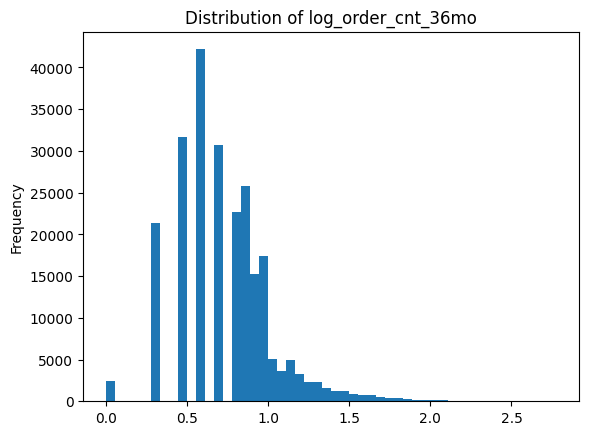

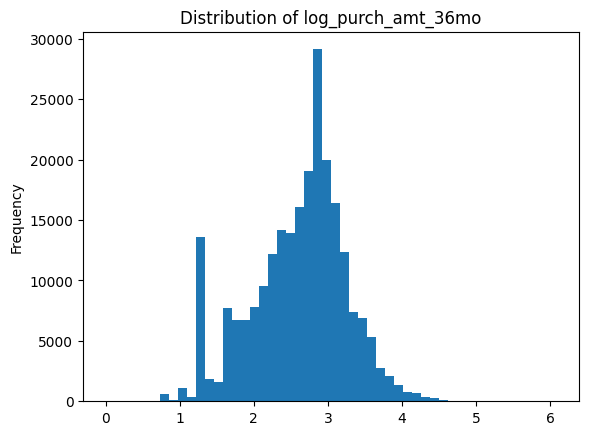

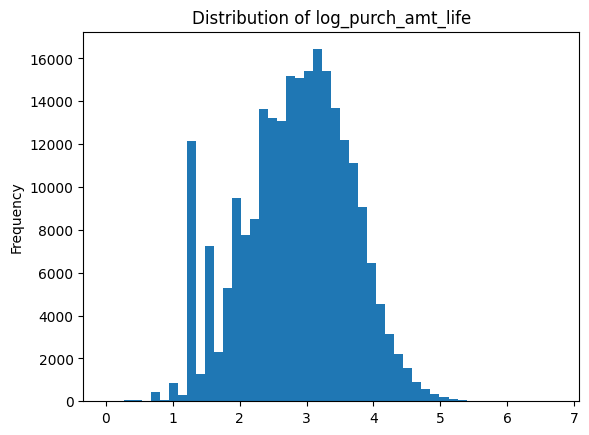

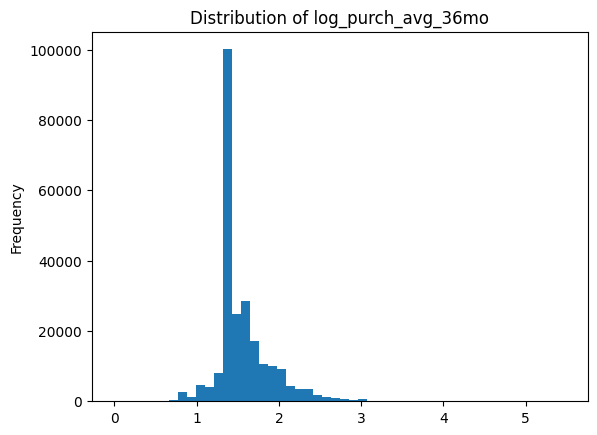

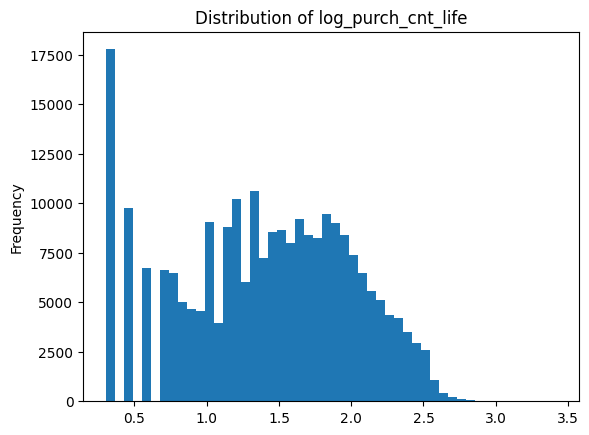

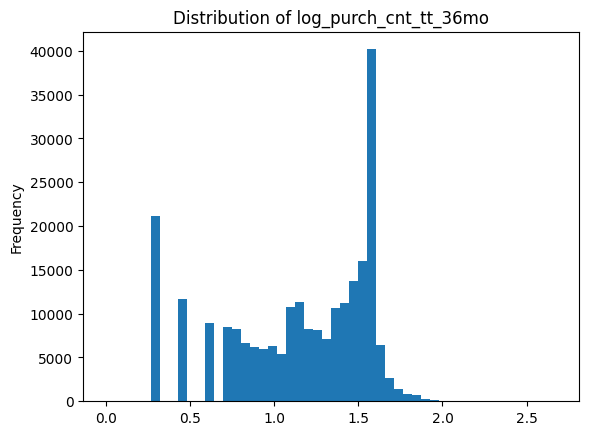

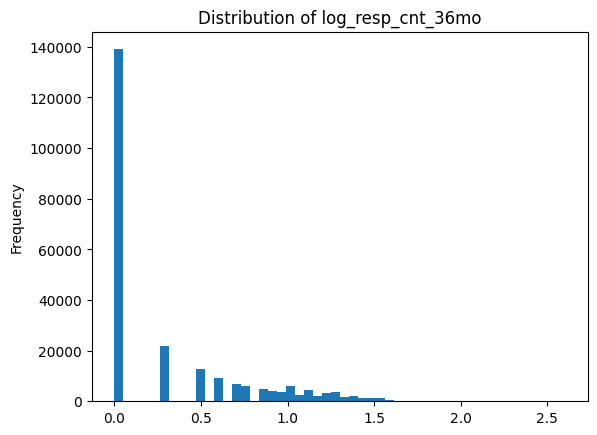

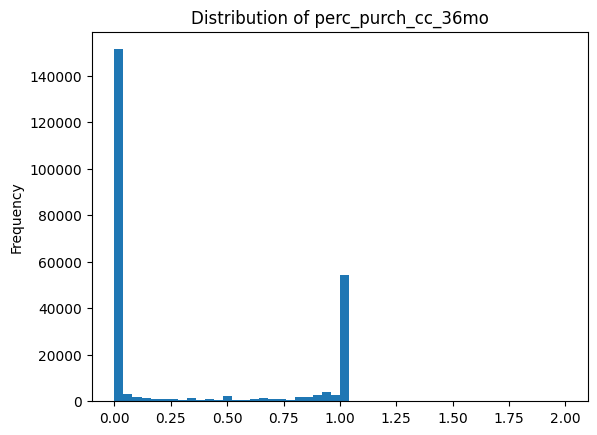

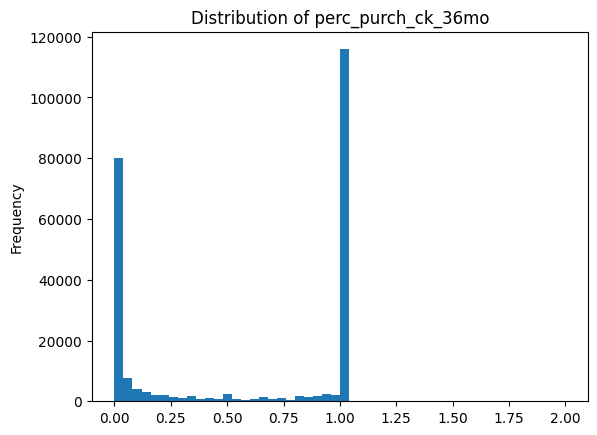

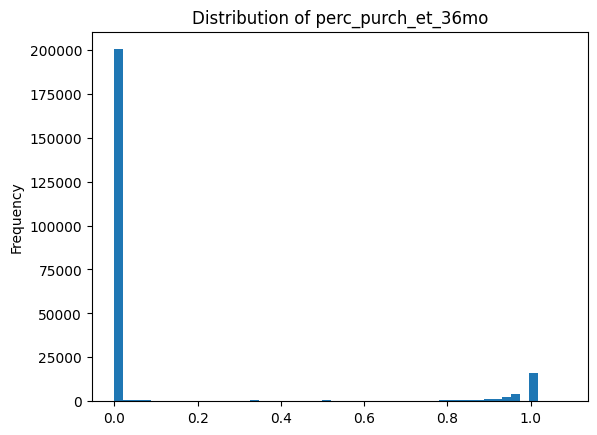

In [28]:
# draw histograms for all transformed variables
transformed_columns = ['log_order_cnt_36mo','log_purch_amt_36mo','log_purch_amt_life','log_purch_avg_36mo','log_purch_cnt_life',
                       'log_purch_cnt_tt_36mo','log_resp_cnt_36mo','perc_purch_cc_36mo','perc_purch_ck_36mo','perc_purch_et_36mo']

for col in transformed_columns:
    combined_df[col].plot.hist(title="Distribution of "+col,bins=50)
    plt.show()


# Churn Model

## Train Test Split

In [29]:

model_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date',
                            'ST'
                              ],axis=1)


In [30]:
model_df.shape

(239356, 132)

In [31]:
margin_df.shape

(240368, 97)

In [32]:
churn_df.shape

(240368, 30)

In [33]:
# columns in margin_df
columns = margin_df.columns.drop('acct_ID')

# model using only churn and demog data
model_df = model_df.drop(columns, axis=1)

model_df.shape

(239356, 36)

In [34]:
categorical_vars = model_df.select_dtypes(include=['object']).columns.drop('acct_ID')

model_df = pd.get_dummies(model_df, columns=categorical_vars, drop_first=True)

x_train_df, x_test_df = train_test_split(model_df, test_size = 0.30, random_state=12345)

# will need the acct_IDs to rejoin data later, so pulling out now before dropping from actual model training data 

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]

# the target (or dependent) variable is stored in it's own dataframe

y_train_df = x_train_df[['churn_year_plus1_ind']]
y_test_df  = x_test_df[['churn_year_plus1_ind']]

# and we want to drop acct_ID and the target variable from the dataframe of independent variables
# one-hot encoding categorical variables


x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind'
                             ],axis=1)

# categorical_vars = x_train_df.select_dtypes(include=['object']).columns

# x_train_df = pd.get_dummies(x_train_df, columns=categorical_vars, drop_first=True)

# standard scaling x_train_df
scaler = StandardScaler()
x_train_df = pd.DataFrame(scaler.fit_transform(x_train_df), columns=x_train_df.columns)

# for x_test_df
x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind'
                             ],axis=1)

# x_test_df = pd.get_dummies(x_test_df, columns=categorical_vars, drop_first=True)

x_test_df = pd.DataFrame(scaler.transform(x_test_df), columns=x_test_df.columns)


In [35]:

x_train_df.shape

(167549, 114)

In [36]:
x_test_df.shape

(71807, 114)

## Logistic Regression Feature Selection

In [37]:
""" models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero """
""" SelectFromModel can be used to to select effects with non-zero coefficients """
""" the parameter C controls the sparsity: the smaller C the fewer features selected """

""" using the ravel simply to avoid warning in log """
y_train_array=np.ravel(y_train_df)

""" start with C = 1.0, then try 0.1, etc """
model1 = linear_model.LogisticRegression(C=0.01, solver='liblinear', penalty='l1', tol=0.01, random_state=12345)
model1_fit = model1.fit(x_train_df, y_train_array)
model1_selects = SelectFromModel(model1_fit, prefit=True)
"""x_train_selected_df = model1_selects.transform(x_train_df)"""

""" in lieu of commented-out transform method above, can use this method to explicitly define columns to keep """
x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]

coefficients = pd.DataFrame(model1_fit.coef_)
coefficients = np.transpose(coefficients[coefficients.columns[model1_selects.get_support()]])
coefficients = coefficients.reset_index(drop=True)

coefficients_match = pd.concat([pd.DataFrame(x_train_selected_df.columns),coefficients], axis = 1)

coefficients.shape 

(68, 1)

In [38]:
print(" ") 
print("Coefficients for selected variables")
# change coeffients_match column names
coefficients_match.columns = ['Variable', 'Coefficient']
coefficients_match.sort_values(by='Coefficient', ascending=False)

 
Coefficients for selected variables


,Variable,Coefficient
4,months_since_last_trans,1.345036
18,perc_purch_et_36mo,0.155679
24,tier_prev_xxx,0.132292
19,tier_2-Silver,0.068608
20,tier_3-Gold,0.058272
6,purch_avg_interval,0.044418
27,demog_assets_IPA <= 25000,0.042940
22,tier_5-Diamond,0.021226
66,region_South,0.020413
21,tier_4-Platinum,0.020044


## VIF Feature Selection

In [39]:
def calculate_vif_(X, thresh=10):
    # Add an intercept (constant) term to the model
    X = add_constant(X)
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped = True
    while dropped:
        dropped = False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        # Drop variables with VIF values greater than 10    
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped = True

            print('Remaining variables:')
            print(X.columns[variables])
    # Return the dataframe without the constant term for further analysis
    return X.iloc[:, variables]

# apply calculate_vif_ to x_train_selected_df until all VIF values are below 10
x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape



dropping 'log_purch_cnt_life' at index: 16
Remaining variables:
Index(['const', 'emailable', 'solicit_email_ind', 'fixd_incm_flg',
       'scheduled_purchase_flg', 'months_since_last_trans',
       'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo',
       'call_in_mo_36mo', 'call_out_mo_36mo', 'demog_span',
       'demog_generations', 'demog_adults', 'log_order_cnt_36mo',
       'log_purch_avg_36mo', 'log_resp_cnt_36mo', 'perc_purch_ck_36mo',
       'perc_purch_et_36mo', 'tier_2-Silver', 'tier_3-Gold', 'tier_4-Platinum',
       'tier_5-Diamond', 'tier_prev_2-Silver', 'tier_prev_xxx',
       'demog_assets_500000 < IPA <= 750000',
       'demog_assets_750000 < IPA <= 1000000', 'demog_assets_IPA <= 25000',
       'demog_LOR_10th Year', 'demog_LOR_11th Year',
       'demog_LOR_13 - 18 Months', 'demog_LOR_15th Year',
       'demog_LOR_16th Year', 'demog_LOR_17th Year', 'demog_LOR_18th Year',
       'demog_LOR_19 - 24 Months', 'demog_LOR_20 or more Years',
       'demog_LOR_4

(167549, 68)

In [40]:
""" reducing the test set to have the same columns as the training set """

selected_columns = x_train_selected_df.columns.drop(['const'])


In [41]:

x_test_selected_df=x_test_selected_df[selected_columns]
print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['emailable', 'solicit_email_ind', 'fixd_incm_flg',
       'scheduled_purchase_flg', 'months_since_last_trans',
       'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo',
       'call_in_mo_36mo', 'call_out_mo_36mo', 'demog_span',
       'demog_generations', 'demog_adults', 'log_order_cnt_36mo',
       'log_purch_avg_36mo', 'log_resp_cnt_36mo', 'perc_purch_ck_36mo',
       'perc_purch_et_36mo', 'tier_2-Silver', 'tier_3-Gold', 'tier_4-Platinum',
       'tier_5-Diamond', 'tier_prev_2-Silver', 'tier_prev_xxx',
       'demog_assets_500000 < IPA <= 750000',
       'demog_assets_750000 < IPA <= 1000000', 'demog_assets_IPA <= 25000',
       'demog_LOR_10th Year', 'demog_LOR_11th Year',
       'demog_LOR_13 - 18 Months', 'demog_LOR_15th Year',
       'demog_LOR_16th Year', 'demog_LOR_17th Year', 'demog_LOR_18th Year',
       'demog_LOR_19 - 24 Months', 'demog_LOR_20 or more Years',
       'demog_LOR_4th Year', 'demog_LOR_5th Year', 'demog_L

(71807, 67)

## Logistic Regression

In [42]:
x_train_selected_df.shape

(167549, 68)

In [43]:
y_train_df.shape

(167549, 1)

In [44]:
x_train_selected_df.drop(['const'], axis=1, inplace=True)

In [45]:
x_train_selected_df.shape

(167549, 67)

In [46]:
y_train_df.head()

,churn_year_plus1_ind
215192,0
23313,1
135692,0
41287,0
47777,1


In [47]:
""" for the statsmodels, need to add a constant to fit intercept """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')


In [48]:
x_train_selected_df.shape

(167549, 68)

In [49]:

""" modeling with selected variables from steps above """

model = sm.Logit(y_train_df.reset_index(drop=True), x_train_selected_df)
result = model.fit(maxiter=100)

print(" ") 
print("Logistic model with selected variables")
print(" ") 
print(result.summary2())
print('AIC: ', result.aic)
print('BIC: ', result.bic)

Optimization terminated successfully.
         Current function value: 0.316852
         Iterations 10
 
Logistic model with selected variables
 
                                    Results: Logit
Model:                    Logit                     Pseudo R-squared:      0.450      
Dependent Variable:       churn_year_plus1_ind      AIC:                   106312.5351
Date:                     2024-02-06 11:26          BIC:                   106994.5092
No. Observations:         167549                    Log-Likelihood:        -53088.    
Df Model:                 67                        LL-Null:               -96595.    
Df Residuals:             167481                    LLR p-value:           0.0000     
Converged:                1.0000                    Scale:                 1.0000     
No. Iterations:           10.0000                                                     
--------------------------------------------------------------------------------------
                    

AROC train:  0.9194450283890083
AROC test:  0.9191249864807667
 
MSE train: 0.0997233488666412
MSE test: 0.10036101275503552
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.0997233488666412
mean squared error testn: 0.10036101275503552


<AxesSubplot:title={'center':'P_churn_year_plus1_ind'}, xlabel='churn_year_plus1_ind'>

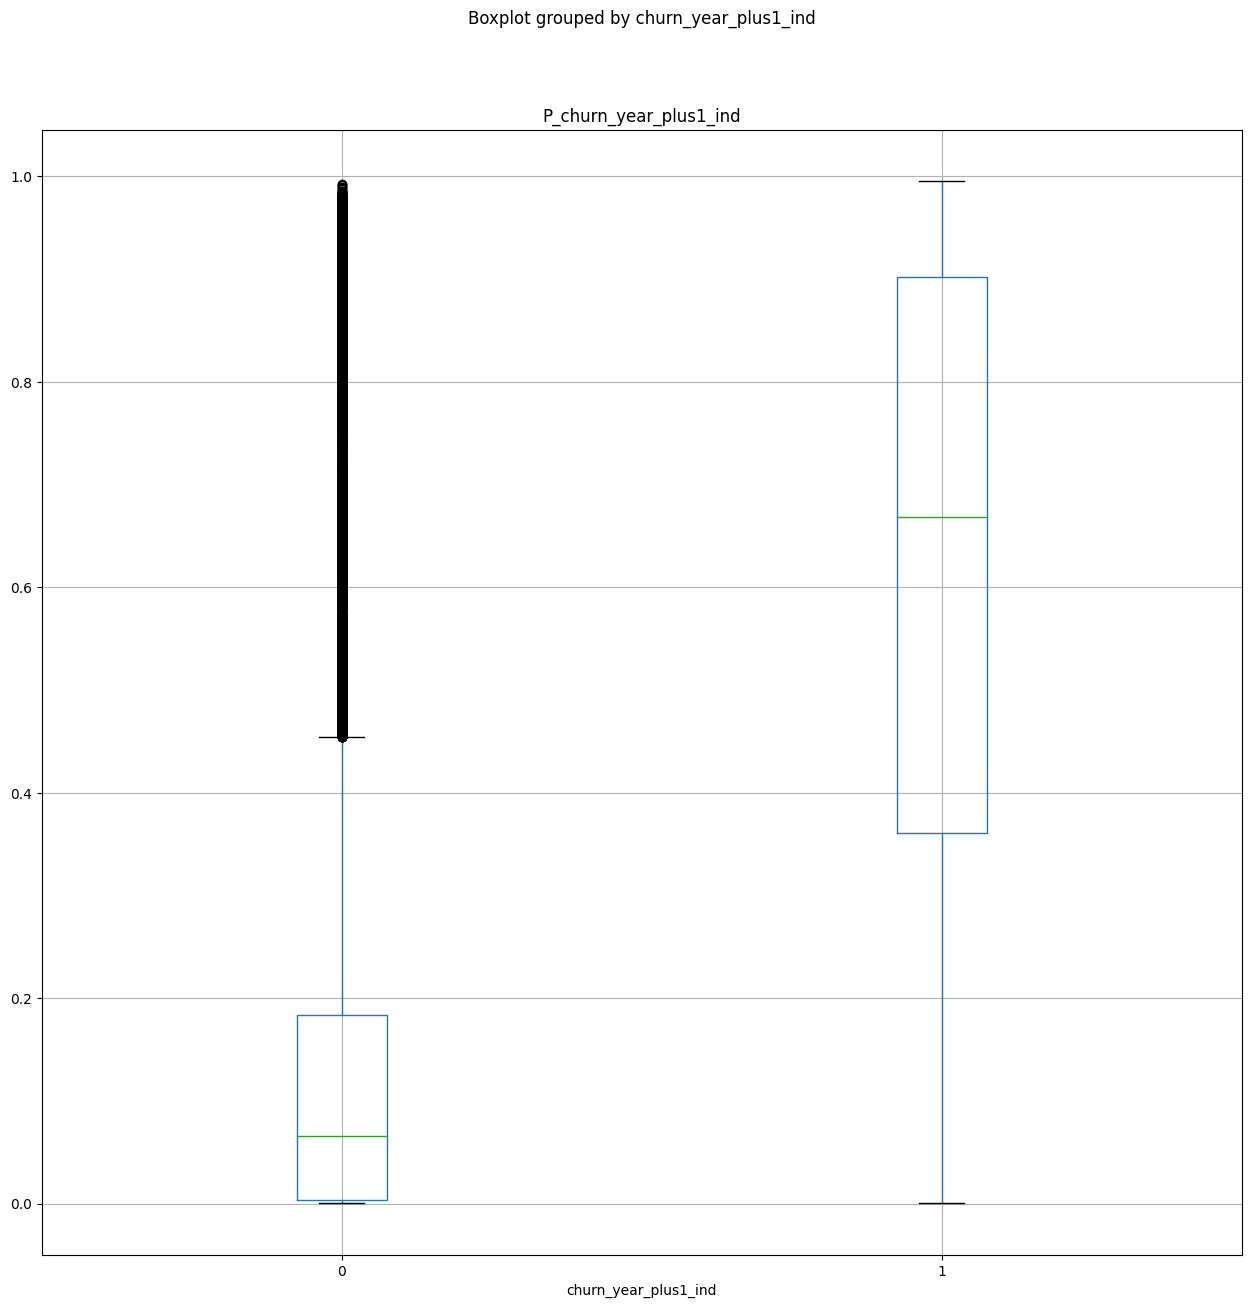

In [50]:
""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """
train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error testn:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))

pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

## Advanced Machine Learning: Gradient Boosting

In [51]:
# from tqdm import tqdm
# """ Gradient Boosting """
# # Define the parameter grid explicitly
# param_grid = {
#     "n_estimators": [50, 100],  # Example values, should be adjusted
#     "max_depth": [3, 5],          # Example values, should be adjusted
#     "min_samples_split": [2, 4],  # Example values, should be adjusted
#     "learning_rate": [0.01, 0.05],  # Example values, should be adjusted
# }
# model2 = GradientBoostingClassifier()

# # Calculate the number of fits that will be performed
# total_fits = 1
# for v in param_grid.values():
#     total_fits *= len(v)

# grid_search = GridSearchCV(model2, param_grid=param_grid,
#                            verbose=1,  # Controls the verbosity: the higher, the more messages
#                            n_jobs=-1)  # Number of jobs to run in parallel

# # Fit the GridSearchCV with a tqdm progress bar
# for _ in tqdm(range(total_fits), desc="Fitting models"):
#     grid_search.fit(x_train_selected_df, y_train_array)


# # The best model can be accessed like this
# best_model = grid_search.best_estimator_

# # Print the best parameters
# print("Best parameters found: ", grid_search.best_params_)

GB overall accuracy: 0.8794964279248542
AROC train:  0.9413225965287443
AROC test:  0.9385012488643162
 
MSE train: 0.08401136307260246
MSE test: 0.0860345154964199
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.08401136307260246
mean squared error test: 0.0860345154964199


Text(0, 0.5, 'AROC')

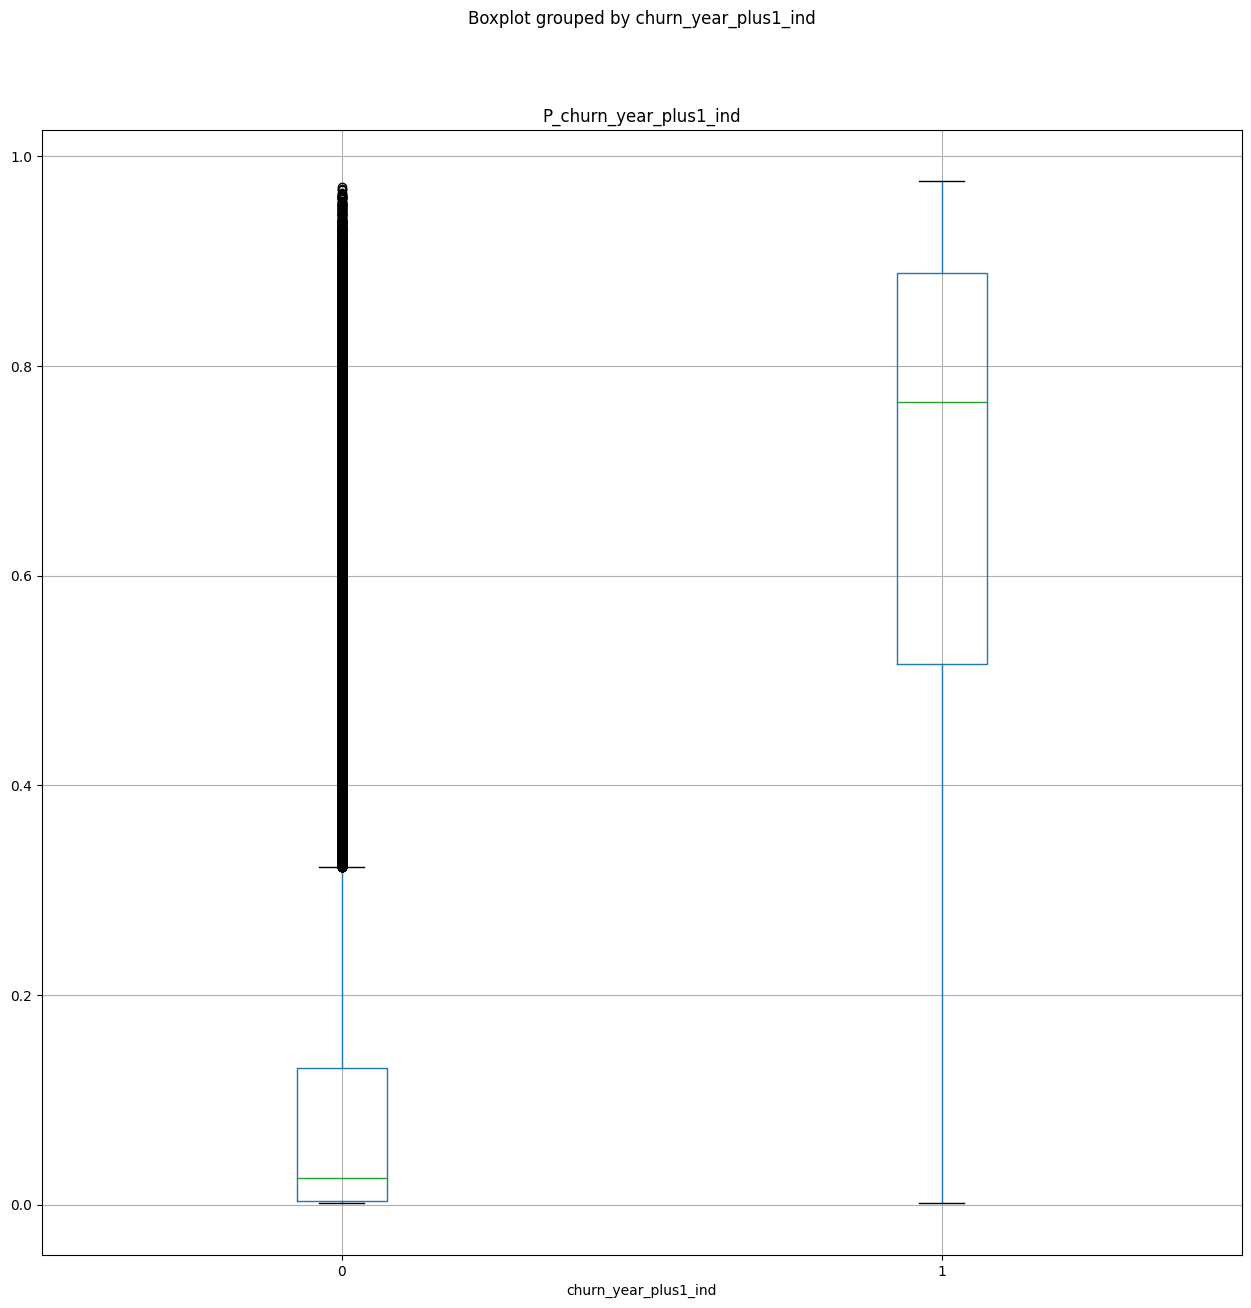

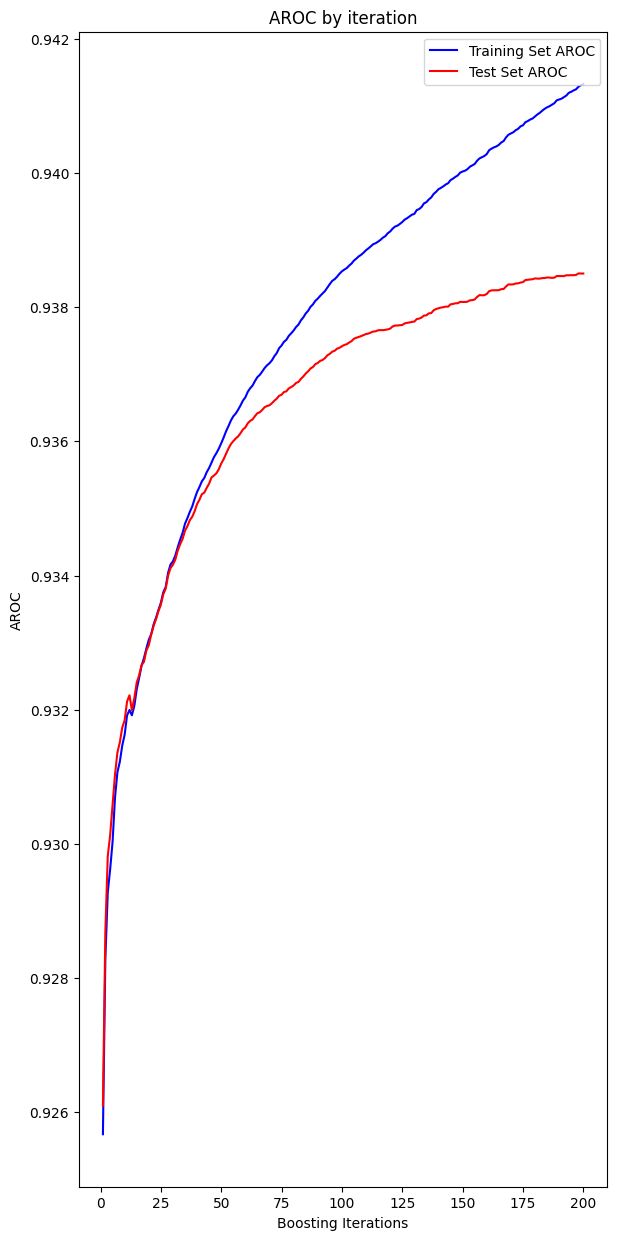

In [52]:
""" Gradient Boosting """
params = {'n_estimators': 200, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.05}
model2 = GradientBoostingClassifier(**params)
""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result = model2.fit(x_train_selected_df, y_train_array)

""" returns overall accuracy"""
accuracy = model2.score(x_test_selected_df, y_test_df)
print("GB overall accuracy:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model2.predict_proba(x_train_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(model2.predict_proba(x_test_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)


test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error test:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))


pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

""" plotting AROC with each iteration of the Gradient Boosting algorithm """

""" converting Y dataframes into arrays as needed for logic below """
y_traint_array = y_train_df.values
y_test_array = y_test_df.values

test_AROC  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_AROC = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model2.staged_predict_proba(x_test_selected_df)):
    test_AROC[i] = metrics.roc_auc_score(y_test_array, y_pred[:, 1])

for i, y_pred in enumerate(model2.staged_predict_proba(x_train_selected_df)):
    train_AROC[i] = metrics.roc_auc_score(y_train_array, y_pred[:, 1])

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('AROC by iteration')
plt.plot(np.arange(params['n_estimators']) + 1, train_AROC, 'b-',
         label='Training Set AROC')
plt.plot(np.arange(params['n_estimators']) + 1, test_AROC, 'r-',
         label='Test Set AROC')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('AROC')


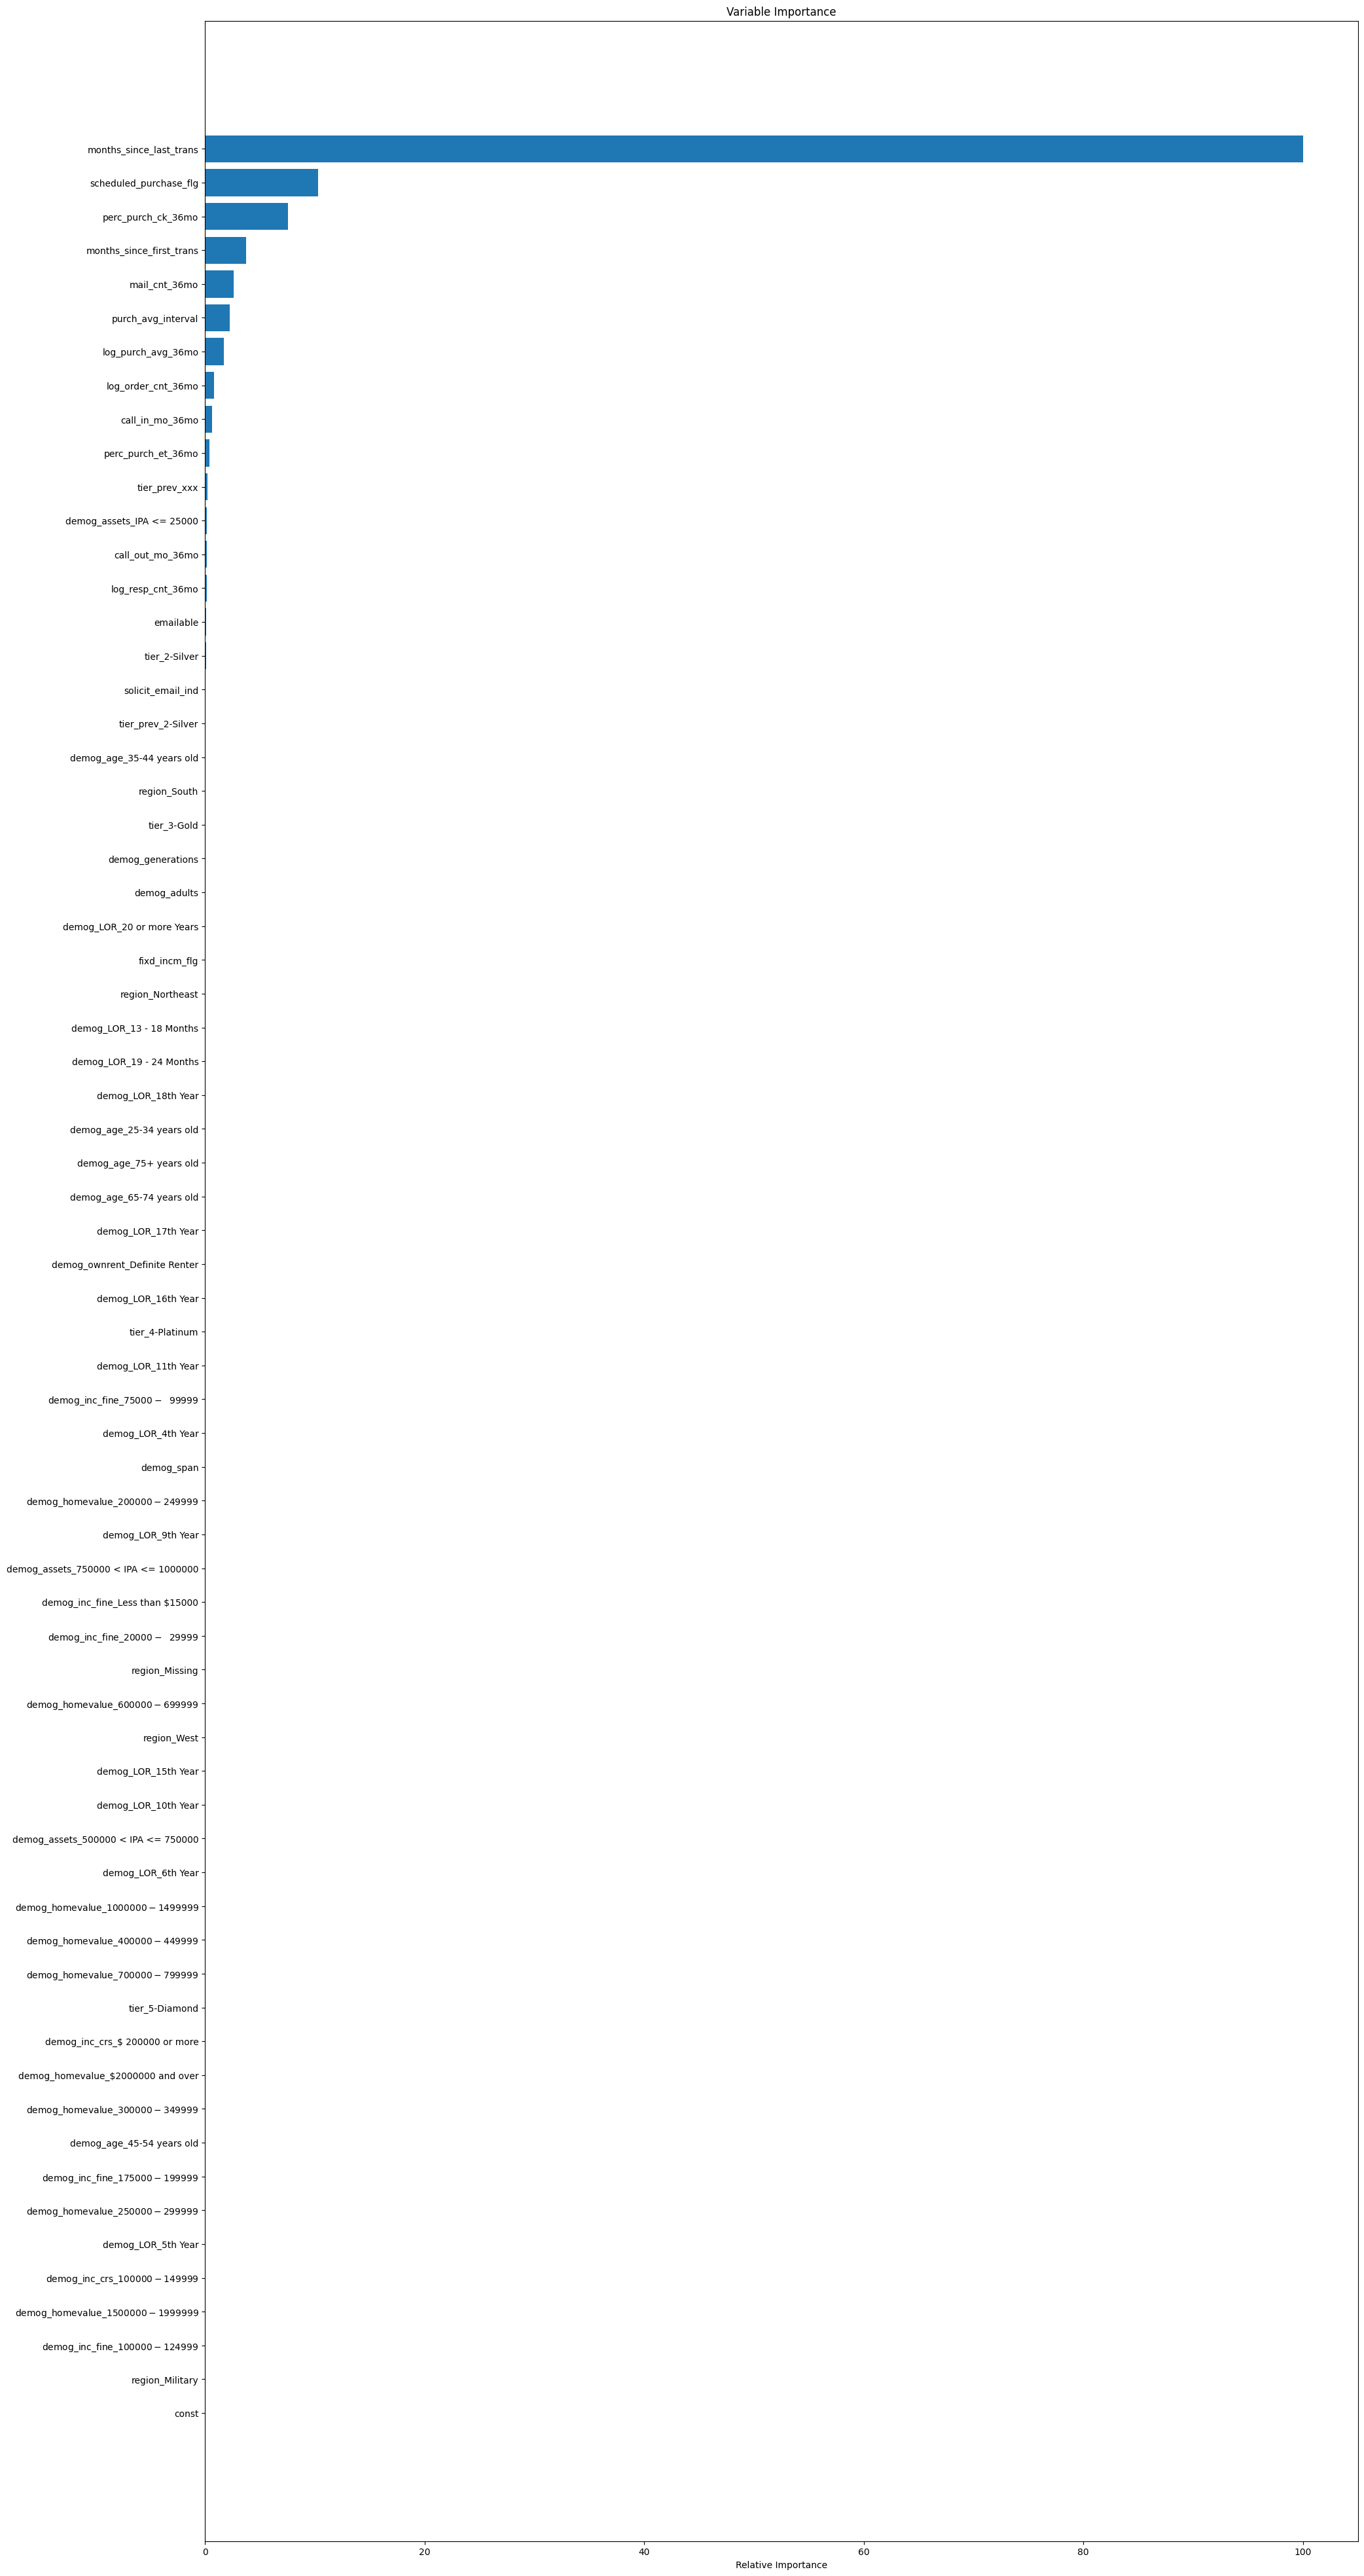

In [53]:
feature_importance = model2.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# export the feature importance to a csv
feature_importance_df = pd.DataFrame({'Variable': x_train_selected_df.columns[sorted_idx], 'Importance': feature_importance[sorted_idx]})
feature_importance_df.to_csv('churn_feature_importance.csv', index=False)

In [54]:
""" append together train and test predicted values, keeping only acct ID and predicted values """

pred_v_actual_train = pd.concat([pred_v_actual_train, pred_v_actual_test], ignore_index=True)

pred_v_actual_train = pred_v_actual_train.drop(['churn_year_plus1_ind'
                             ],axis=1)


In [55]:

""" and then save predicted values by acct ID to csv """

## Change the path
pred_v_actual_train.to_csv('churn_scores.csv',index=False)
pred_v_actual_train.shape

(239356, 2)

In [56]:
x_test_selected_df.shape

(71807, 68)

In [57]:
# # merge acct_ID back to x_test_selected_df and x_train_selected_df
# x_test_selected_df = pd.concat([x_test_selected_df, test_acct_IDs_df], axis=1)
# x_train_selected_df = pd.concat([x_train_selected_df, train_acct_IDs_df], axis=1)

In [58]:
test_acct_IDs_df.shape

(71807, 1)

In [59]:
# do the same for y_train_df and y_test_df
y_test_df = pd.concat([y_test_df, test_acct_IDs_df.reset_index(drop=True)], axis=1)
y_train_df = pd.concat([y_train_df, train_acct_IDs_df.reset_index(drop=True)], axis=1)

In [60]:
# keep only yhe first column in y_test_df and y_train_df
# y_test_df = y_test_df.iloc[:, 0]
# y_train_df = y_train_df.iloc[:, 0]

In [61]:
y_test_df.head()

,churn_year_plus1_ind,acct_ID
0,0,I1348346
1,1,I148597353
2,0,H59114986
3,0,I149210574
4,0,H48658230


In [62]:
# union the two dataframes
y_acct_df = pd.concat([y_train_df, y_test_df], axis=0)


In [63]:
y_acct_df.shape

(239356, 2)

In [64]:
# merge the two dataframes
combined_df = pd.merge(pred_v_actual_train, y_acct_df, on='acct_ID')

In [65]:
combined_df.shape

(239356, 3)

In [66]:
combined_df.head()

,P_churn_year_plus1_ind,acct_ID,churn_year_plus1_ind
0,0.132920,H152903826,0
1,0.720361,I148541362,1
2,0.002640,I5772185,0
3,0.019118,I136051787,0
4,0.802771,I133533808,1


In [67]:
combined_df.tail()

,P_churn_year_plus1_ind,acct_ID,churn_year_plus1_ind
239351,0.093220,H150636817,0
239352,0.025014,I60344235,0
239353,0.063930,I119311396,0
239354,0.422767,I59271268,1
239355,0.002979,I150548729,0


In [68]:
# combined x_test_selected_df and x_train_selected_df
combined_x_df = pd.concat([x_train_selected_df, x_test_selected_df], axis=0)

In [69]:
combined_x_df.shape

(239356, 68)

In [70]:
combined_x_df.head()

,const,emailable,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,demog_span,demog_generations,demog_adults,log_order_cnt_36mo,log_purch_avg_36mo,log_resp_cnt_36mo,perc_purch_ck_36mo,perc_purch_et_36mo,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_2-Silver,tier_prev_xxx,demog_assets_500000 < IPA <= 750000,demog_assets_750000 < IPA <= 1000000,demog_assets_IPA <= 25000,demog_LOR_10th Year,demog_LOR_11th Year,demog_LOR_13 - 18 Months,demog_LOR_15th Year,demog_LOR_16th Year,demog_LOR_17th Year,demog_LOR_18th Year,demog_LOR_19 - 24 Months,demog_LOR_20 or more Years,demog_LOR_4th Year,demog_LOR_5th Year,demog_LOR_6th Year,demog_LOR_9th Year,demog_ownrent_Definite Renter,demog_age_25-34 years old,demog_age_35-44 years old,demog_age_45-54 years old,demog_age_65-74 years old,demog_age_75+ years old,demog_inc_fine_$ 20000 - $ 29999,demog_inc_fine_$ 75000 - $ 99999,demog_inc_fine_$ 100000 - $124999,demog_inc_fine_$ 175000 - $199999,demog_inc_fine_Less than $15000,demog_inc_crs_$ 100000 - $149999,demog_inc_crs_$ 200000 or more,demog_homevalue_$1000000 - $1499999,demog_homevalue_$1500000 - $1999999,demog_homevalue_$200000 - $249999,demog_homevalue_$2000000 and over,demog_homevalue_$250000 - $299999,demog_homevalue_$300000 - $349999,demog_homevalue_$400000 - $449999,demog_homevalue_$600000 - $699999,demog_homevalue_$700000 - $799999,region_Military,region_Missing,region_Northeast,region_South,region_West
0,1.0,-1.029298,0.193666,-0.318952,-0.593717,-0.615499,-1.110848,3.091570,-1.223675,-0.167377,-0.536991,-0.120627,-0.610444,-0.925726,-1.505672,1.322781,-0.717640,0.934418,-0.410919,1.980946,-0.356074,-0.152274,-0.142444,3.839808,-1.441672,-0.158795,-0.119167,1.039658,-0.195746,-0.188277,-0.176179,-0.163339,-0.155707,-0.156169,-0.153684,-0.181352,-0.595556,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,-0.253567,2.370682,-0.522952,-0.485793,-0.403475,-0.474348,-0.301023,-0.201284,-0.056225,2.997704,-0.265566,-0.073898,-0.045622,-0.02456,-0.303188,-0.027758,-0.23657,-0.188447,-0.120805,-0.082402,-0.056545,-0.019851,-0.062695,-0.393600,1.095401,-0.517061
1,1.0,-1.029298,0.193666,-0.318952,-0.593717,1.315257,-0.818563,-0.306227,-0.817122,-0.167377,-0.114227,-0.120627,-0.610444,-0.925726,0.140765,-0.134837,-0.047040,0.934418,-0.410919,-0.504809,-0.356074,-0.152274,-0.142444,-0.260430,0.693639,-0.158795,-0.119167,1.039658,-0.195746,-0.188277,5.676045,-0.163339,-0.155707,-0.156169,-0.153684,-0.181352,-0.595556,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,3.943723,-0.421819,-0.522952,-0.485793,-0.403475,-0.474348,-0.301023,-0.201284,-0.056225,-0.333589,-0.265566,-0.073898,-0.045622,-0.02456,-0.303188,-0.027758,-0.23657,-0.188447,-0.120805,-0.082402,-0.056545,-0.019851,-0.062695,2.540651,-0.912908,-0.517061
2,1.0,0.971536,0.193666,-0.318952,1.684305,-0.615499,1.794806,-0.390749,1.147885,-0.167377,-0.959756,-0.120627,-0.610444,-0.925726,-0.466886,-0.358314,-0.717640,-1.194620,2.692550,-0.504809,-0.356074,-0.152274,-0.142444,-0.260430,0.693639,6.297409,-0.119167,-0.961855,-0.195746,-0.188277,-0.176179,-0.163339,-0.155707,-0.156169,-0.153684,-0.181352,1.679104,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,-0.253567,-0.421819,-0.522952,-0.485793,2.478470,-0.474348,-0.301023,-0.201284,-0.056225,-0.333589,-0.265566,-0.073898,-0.045622,-0.02456,-0.303188,-0.027758,-0.23657,-0.188447,-0.120805,-0.082402,-0.056545,-0.019851,-0.062695,-0.393600,-0.912908,1.934008
3,1.0,0.971536,0.193666,-0.318952,-0.593717,-0.615499,-0.216801,-0.375834,0.876850,-0.145764,1.154067,-0.120627,1.140315,1.459433,-0.466886,-0.551264,2.078712,0.934418,-0.410919,-0.504809,-0.356074,-0.152274,-0.142444,-0.260430,0.693639,-0.158795,-0.119167,-0.961855,-0.195746,-0.188277,-0.176179,-0.163339,-0.155707,-0.156169,-0.153684,-0.181352,1.679104,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,-0.253567,-0.421819,-0.522952,-0.485793,2.4784

In [71]:
# concat combined_df and combined_x_df at axis 1
combined_final_df = pd.concat([combined_df, combined_x_df.reset_index(drop=True)], axis=1)

In [73]:
combined_final_df.head()

,P_churn_year_plus1_ind,acct_ID,churn_year_plus1_ind,const,emailable,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,demog_span,demog_generations,demog_adults,log_order_cnt_36mo,log_purch_avg_36mo,log_resp_cnt_36mo,perc_purch_ck_36mo,perc_purch_et_36mo,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_2-Silver,tier_prev_xxx,demog_assets_500000 < IPA <= 750000,demog_assets_750000 < IPA <= 1000000,demog_assets_IPA <= 25000,demog_LOR_10th Year,demog_LOR_11th Year,demog_LOR_13 - 18 Months,demog_LOR_15th Year,demog_LOR_16th Year,demog_LOR_17th Year,demog_LOR_18th Year,demog_LOR_19 - 24 Months,demog_LOR_20 or more Years,demog_LOR_4th Year,demog_LOR_5th Year,demog_LOR_6th Year,demog_LOR_9th Year,demog_ownrent_Definite Renter,demog_age_25-34 years old,demog_age_35-44 years old,demog_age_45-54 years old,demog_age_65-74 years old,demog_age_75+ years old,demog_inc_fine_$ 20000 - $ 29999,demog_inc_fine_$ 75000 - $ 99999,demog_inc_fine_$ 100000 - $124999,demog_inc_fine_$ 175000 - $199999,demog_inc_fine_Less than $15000,demog_inc_crs_$ 100000 - $149999,demog_inc_crs_$ 200000 or more,demog_homevalue_$1000000 - $1499999,demog_homevalue_$1500000 - $1999999,demog_homevalue_$200000 - $249999,demog_homevalue_$2000000 and over,demog_homevalue_$250000 - $299999,demog_homevalue_$300000 - $349999,demog_homevalue_$400000 - $449999,demog_homevalue_$600000 - $699999,demog_homevalue_$700000 - $799999,region_Military,region_Missing,region_Northeast,region_South,region_West
0,0.132920,H152903826,0,1.0,-1.029298,0.193666,-0.318952,-0.593717,-0.615499,-1.110848,3.091570,-1.223675,-0.167377,-0.536991,-0.120627,-0.610444,-0.925726,-1.505672,1.322781,-0.717640,0.934418,-0.410919,1.980946,-0.356074,-0.152274,-0.142444,3.839808,-1.441672,-0.158795,-0.119167,1.039658,-0.195746,-0.188277,-0.176179,-0.163339,-0.155707,-0.156169,-0.153684,-0.181352,-0.595556,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,-0.253567,2.370682,-0.522952,-0.485793,-0.403475,-0.474348,-0.301023,-0.201284,-0.056225,2.997704,-0.265566,-0.073898,-0.045622,-0.02456,-0.303188,-0.027758,-0.23657,-0.188447,-0.120805,-0.082402,-0.056545,-0.019851,-0.062695,-0.393600,1.095401,-0.517061
1,0.720361,I148541362,1,1.0,-1.029298,0.193666,-0.318952,-0.593717,1.315257,-0.818563,-0.306227,-0.817122,-0.167377,-0.114227,-0.120627,-0.610444,-0.925726,0.140765,-0.134837,-0.047040,0.934418,-0.410919,-0.504809,-0.356074,-0.152274,-0.142444,-0.260430,0.693639,-0.158795,-0.119167,1.039658,-0.195746,-0.188277,5.676045,-0.163339,-0.155707,-0.156169,-0.153684,-0.181352,-0.595556,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,3.943723,-0.421819,-0.522952,-0.485793,-0.403475,-0.474348,-0.301023,-0.201284,-0.056225,-0.333589,-0.265566,-0.073898,-0.045622,-0.02456,-0.303188,-0.027758,-0.23657,-0.188447,-0.120805,-0.082402,-0.056545,-0.019851,-0.062695,2.540651,-0.912908,-0.517061
2,0.002640,I5772185,0,1.0,0.971536,0.193666,-0.318952,1.684305,-0.615499,1.794806,-0.390749,1.147885,-0.167377,-0.959756,-0.120627,-0.610444,-0.925726,-0.466886,-0.358314,-0.717640,-1.194620,2.692550,-0.504809,-0.356074,-0.152274,-0.142444,-0.260430,0.693639,6.297409,-0.119167,-0.961855,-0.195746,-0.188277,-0.176179,-0.163339,-0.155707,-0.156169,-0.153684,-0.181352,1.679104,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,-0.253567,-0.421819,-0.522952,-0.485793,2.478470,-0.474348,-0.301023,-0.201284,-0.056225,-0.333589,-0.265566,-0.073898,-0.045622,-0.02456,-0.303188,-0.027758,-0.23657,-0.188447,-0.120805,-0.082402,-0.056545,-0.019851,-0.062695,-0.393600,-0.912908,1.934008
3,0.019118,I136051787,0,1.0,0.971536,0.193666,-0.318952,-0.593717,-0.615499,-0.216801,-0.375834,0.876850,-0.145764,1.154067,-0.120627,1.140315,1.459433,-0.466886,-0.551264,2.078712,0.934418,-0.410919,-0.504809,-0.356074,-0.152274,-0.142444,-0.260430,0.693639,-0.158795,-0.119167,-0.961855,-0.195746,-0.188277,-0.176179,-0.163339,-0.1557

In [74]:
combined_final_df.tail()

,P_churn_year_plus1_ind,acct_ID,churn_year_plus1_ind,const,emailable,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,demog_span,demog_generations,demog_adults,log_order_cnt_36mo,log_purch_avg_36mo,log_resp_cnt_36mo,perc_purch_ck_36mo,perc_purch_et_36mo,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_2-Silver,tier_prev_xxx,demog_assets_500000 < IPA <= 750000,demog_assets_750000 < IPA <= 1000000,demog_assets_IPA <= 25000,demog_LOR_10th Year,demog_LOR_11th Year,demog_LOR_13 - 18 Months,demog_LOR_15th Year,demog_LOR_16th Year,demog_LOR_17th Year,demog_LOR_18th Year,demog_LOR_19 - 24 Months,demog_LOR_20 or more Years,demog_LOR_4th Year,demog_LOR_5th Year,demog_LOR_6th Year,demog_LOR_9th Year,demog_ownrent_Definite Renter,demog_age_25-34 years old,demog_age_35-44 years old,demog_age_45-54 years old,demog_age_65-74 years old,demog_age_75+ years old,demog_inc_fine_$ 20000 - $ 29999,demog_inc_fine_$ 75000 - $ 99999,demog_inc_fine_$ 100000 - $124999,demog_inc_fine_$ 175000 - $199999,demog_inc_fine_Less than $15000,demog_inc_crs_$ 100000 - $149999,demog_inc_crs_$ 200000 or more,demog_homevalue_$1000000 - $1499999,demog_homevalue_$1500000 - $1999999,demog_homevalue_$200000 - $249999,demog_homevalue_$2000000 and over,demog_homevalue_$250000 - $299999,demog_homevalue_$300000 - $349999,demog_homevalue_$400000 - $449999,demog_homevalue_$600000 - $699999,demog_homevalue_$700000 - $799999,region_Military,region_Missing,region_Northeast,region_South,region_West
239351,0.093220,H150636817,0,1.0,0.971536,-5.163530,3.135263,-0.593717,-0.615499,-0.921723,-0.409642,-0.275051,0.200048,-0.536991,-0.120627,2.891073,1.459433,1.410570,-0.768581,-0.717640,-1.194620,-0.410919,-0.504809,-0.356074,-0.152274,-0.142444,-0.26043,0.693639,-0.158795,-0.119167,-0.961855,-0.195746,-0.188277,-0.176179,-0.163339,-0.155707,-0.156169,6.506851,-0.181352,-0.595556,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,-0.253567,-0.421819,-0.522952,2.058490,-0.403475,-0.474348,3.322003,-0.201284,-0.056225,-0.333589,-0.265566,-0.073898,-0.045622,-0.02456,3.298287,-0.027758,-0.23657,-0.188447,-0.120805,-0.082402,-0.056545,-0.019851,-0.062695,2.540651,-0.912908,-0.517061
239352,0.025014,I60344235,0,1.0,-1.029298,-5.163530,-0.318952,-0.593717,-0.615499,1.364975,-0.311199,1.554438,-0.167377,-0.959756,-0.120627,1.140315,0.266853,0.140765,-2.760380,1.902321,0.934418,-0.410919,1.980946,-0.356074,-0.152274,-0.142444,-0.26043,-1.441672,-0.158795,-0.119167,1.039658,-0.195746,-0.188277,-0.176179,-0.163339,-0.155707,-0.156169,-0.153684,-0.181352,1.679104,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,-0.253567,-0.421819,1.912223,-0.485793,-0.403475,2.108156,-0.301023,-0.201284,-0.056225,-0.333589,-0.265566,-0.073898,-0.045622,-0.02456,-0.303188,-0.027758,-0.23657,-0.188447,-0.120805,-0.082402,-0.056545,-0.019851,-0.062695,-0.393600,1.095401,-0.517061
239353,0.063930,I119311396,0,1.0,-1.029298,0.193666,-0.318952,-0.593717,-0.615499,0.488121,-0.179941,-0.275051,-0.145764,-0.114227,-0.120627,-0.610444,0.266853,-0.466886,-0.324938,0.623560,0.934418,-0.410919,-0.504809,-0.356074,-0.152274,-0.142444,-0.26043,0.693639,-0.158795,-0.119167,1.039658,-0.195746,-0.188277,-0.176179,-0.163339,-0.155707,-0.156169,-0.153684,-0.181352,1.679104,-0.253407,-0.240108,-0.239008,-0.198832,-0.182001,-0.253567,-0.421819,-0.522952,-0.485793,-0.403475,-0.474348,-0.301023,-0.201284,-0.056225,-0.333589,-0.265566,-0.073898,-0.045622,-0.02456,-0.303188,-0.027758,-0.23657,-0.188447,-0.120805,-0.082402,-0.056545,-0.019851,-0.062695,-0.393600,1.095401,-0.517061
239354,0.422767,I59271268,1,1.0,-1.029298,0.193666,-0.318952,-0.593717,1.637050,1.777612,-0.364895,-0.342810,-0.167377,1.576832,-0.120627,-0.610444,-0.925726,-0.466886,2.701734,0.623560,0.934418,-0.410919,-0.504809,2.808403,-0.152274,-0.142444,-0.26043,-1.441672,-0.158795,8.391604,-0.961855,-0.195746,-0.188277,-0.176179,-0.16

In [75]:
# export to csv
combined_final_df.drop('const', axis=1).to_csv('churn_score_full.csv', index=False)

In [76]:
combined_final_df.shape

(239356, 71)